In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
from scipy.spatial.distance import pdist, cdist
%pylab inline

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(20, 10)

In [3]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_df = df_tcams_nd.copy()
full_df.rename(columns={'pXC50_3D7' : 'POTENCY'}, inplace=True)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])

In [5]:
full_df.dropna(subset=['POTENCY'], inplace=True)
fpa = np.asarray([x for x in full_df.fps.values])

### Bias correction
The main thing we do here is the bias correction...  Let's draw the plot first...

In [6]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0]
i = 0

redo = False

if redo:
    all_dists = np.asarray([])

    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        all_dists = np.concatenate((blk_dists, all_dists))
        i += 10000
        pass
    np.save('all_dists.npy', all_dists)
else:
    all_dists = np.load('all_dists.npy')

Our strategy is going to be the following.  To figure out the ratio of actives to known actives vs random to actives at a known distance, we are going to take multiple 2-fold cross-validation samples of the actives.  Then we're going to calculate 3 ratios:

- 1) for a random compound E(distance to a sample of N/2 actives given distance to N actives)
- 2) for a random compound, distance distribution to a set of N/2 actives
- 3) for an active compound, E(distance to sample of N/2 other actives)

Then, we use 2) and 3) above to calculate the likelihood of being active as a function of distance to (N/2) known actives.  To apply the model - we calculate the distance to our full set of N actives, then translate this via 1) to the distance to N/2 actives, and then we calculate the likelihood of being active from this.

### Distance to N actives as a function of distance to N/2 actives

In [9]:
n_2 = int(fpa.shape[0]/2)

In [7]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0]
i = 0

redo = False

if redo:
    all_distsN = np.asarray([])
    all_distsN2 = np.asarray([])
    
    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        blk_dists2 = nanmin(cdist(fpr, fpa[idcs2], metric='jaccard'),axis=1)
        all_distsN = np.concatenate((blk_dists, all_distsN))
        all_distsN2 = np.concatenate((blk_dists2, all_distsN2))
        i += 10000
        pass
    np.save('all_distsN.npy', all_distsN)
    np.save('all_distsN2.npy', all_distsN2)
    pass

In [66]:
all_distsN = np.load('all_distsN.npy')
all_distsN2 = np.load('all_distsN2.npy')

In [9]:
all_distsN.shape

(499939,)

In [10]:
all_distsN2.shape

(499939,)

In [11]:
np.min(all_distsN2)

0.0

In [12]:
np.min(all_distsN2-all_distsN)

0.0

In [13]:
np.max(all_distsN2-all_distsN)

0.64406779661016944

In [14]:
# Let's plot all the points - we're going to bin all_distsN2 - all_distsN as a function of all_distsN

In [30]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

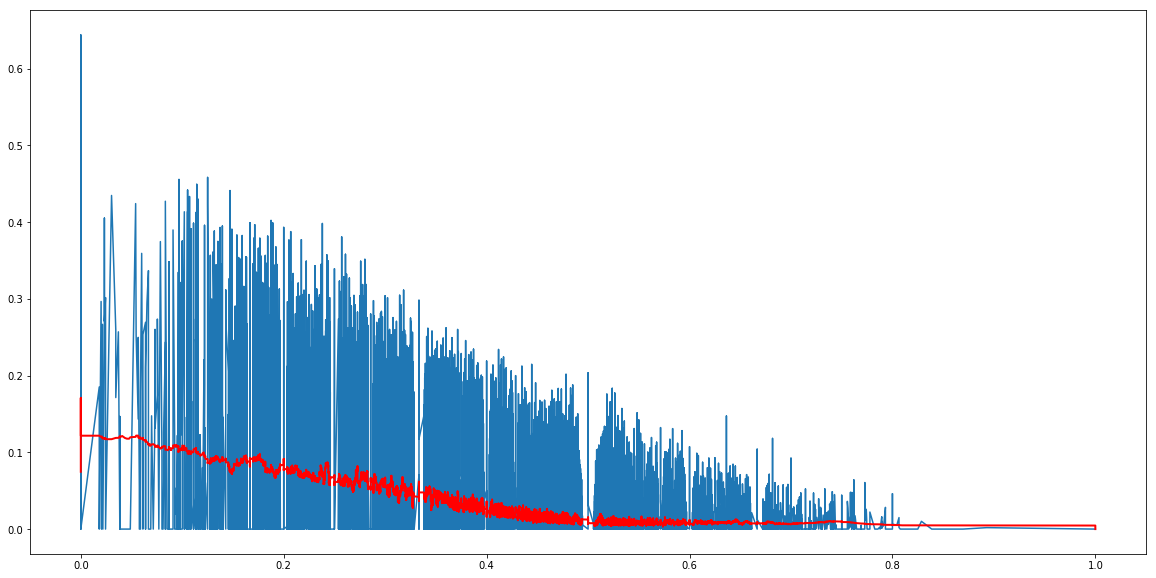

In [36]:
idcs = np.argsort(all_distsN)
x = all_distsN[idcs]
y = (all_distsN2 - all_distsN)[idcs]

plot(x, y)
plot(x, smooth(y,200), 'r-', lw=2)

In [20]:
from sklearn.neighbors import KernelDensity

### Random - N/2 actives...

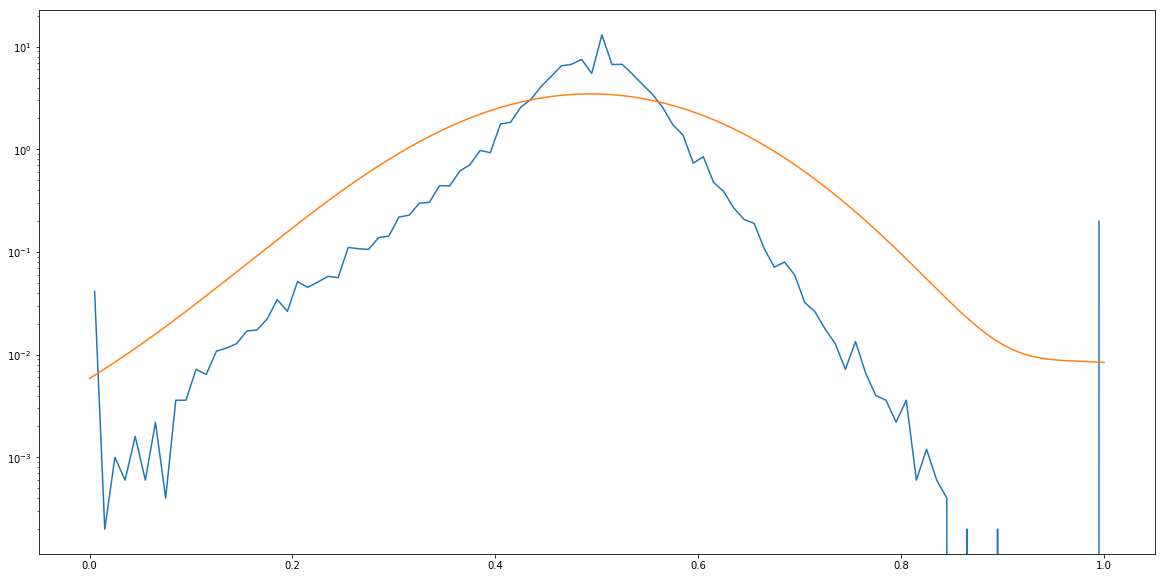

In [83]:
X_plot = np.linspace(0, 1, 1000)[:, np.newaxis]
X = all_distsN2[~np.isnan(all_distsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densRA = kde.score_samples(X_plot)
mra_hist = np.histogram(all_distsN2[~np.isnan(all_distsN2)], density=True, bins=100)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densRA))
_ = plt.yscale('log')

### Actives - N/2 Actives

- we'll do the following:
- collect half a million samples (by doing n/2 splits)
- calculate the density histogram with kernel density estimation
- take the ratio.

In [68]:
n_2 = int(fpa.shape[0]/2)
redo = False
if redo:
    all_AdistsN2 = np.asarray([])
    
    for i in range(100):
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        idcs1 = np.delete(np.arange(fpa.shape[0]), idcs2)
        blk_dists2 = nanmin(cdist(fpa[idcs1], fpa[idcs2], metric='jaccard'),axis=1)
        all_AdistsN2 = np.concatenate((blk_dists2, all_AdistsN2))
        pass
    np.save('all_AdistsN2.npy', all_AdistsN2)
    pass
all_AdistsN2 = np.load('all_AdistsN2.npy')

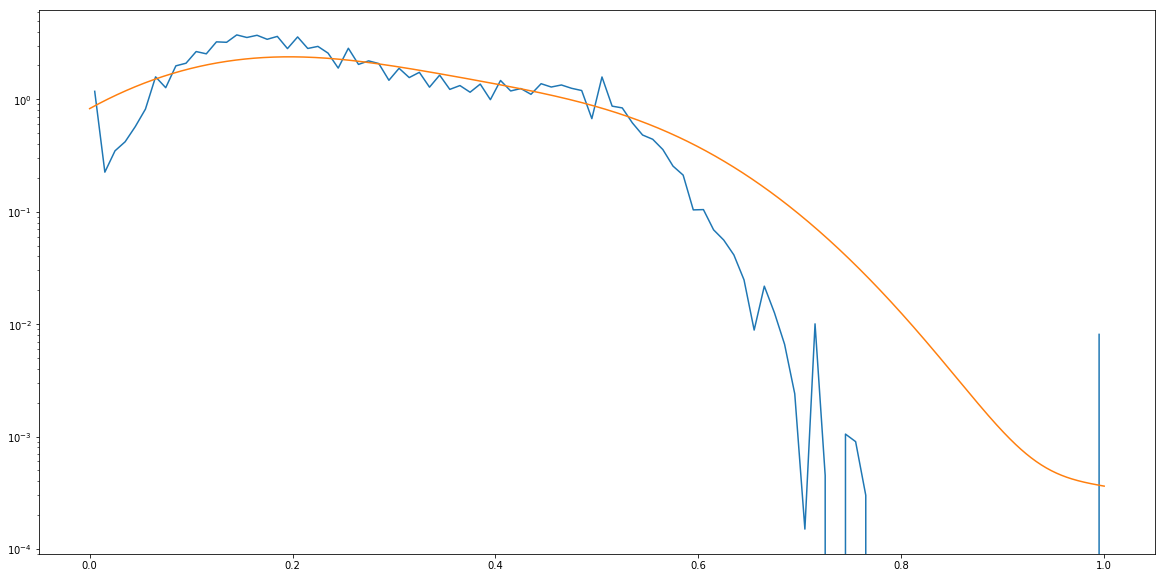

In [79]:
mra_hist = np.histogram(all_AdistsN2[~np.isnan(all_AdistsN2)], density=True, bins=100)
X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densAA = kde.score_samples(X_plot)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densAA))
_ = plt.yscale('log')

In [80]:
all_AdistsN2.shape

(666400,)

In [90]:
df_tcams_nd.shape

(21005, 19)

In [91]:
fa = 21000/2.2e6

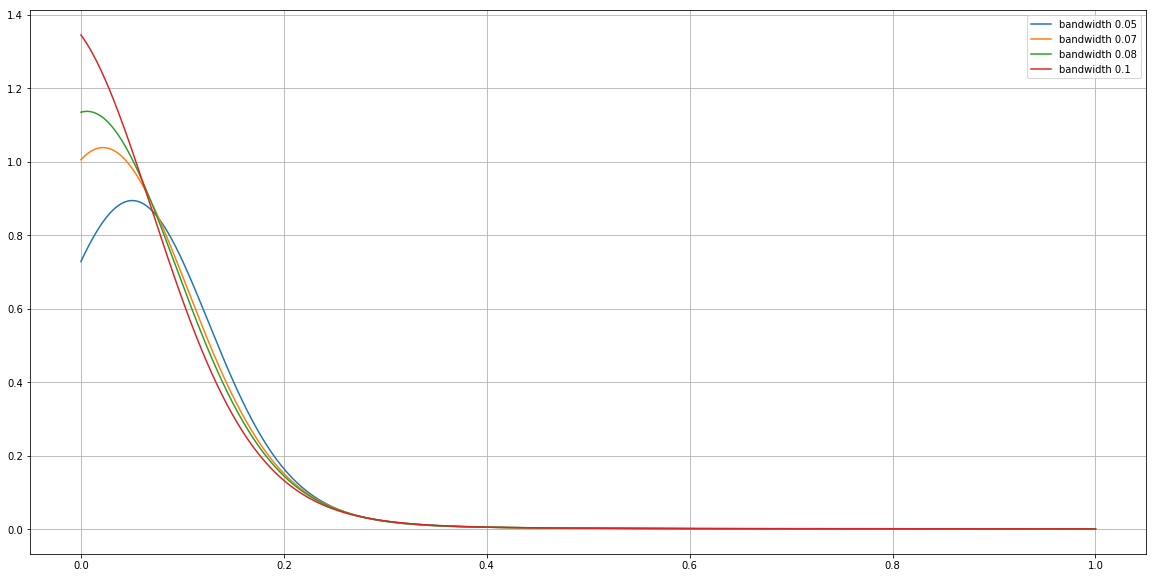

In [93]:
for bandwith in [0.05, 0.07, 0.08, 0.1]:
    X = all_distsN2[~np.isnan(all_distsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densrA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith))
grid(True)
legend(loc='best')
savefig('bandwidth.png')

In [94]:
X = all_distsN2[~np.isnan(all_distsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.07).fit(X)
log_densrA = kde.score_samples(X_plot)
X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.07).fit(X)
log_densAA = kde.score_samples(X_plot)  

In [95]:
from functools import partial

In [101]:
frac_active = partial(np.interp, xp=X_plot[:,0], fp=(fa * np.exp(log_densAA - log_densRA)).clip(0, 1)) 

In [99]:
result_hdr = joblib.load('results/summary_results_tcnd')
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]
inactive_level = 3.5
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=bins, fp=result_hdr['rfb'])

In [100]:
def calc_sigma(distance, ia=inactive_level):
    
    fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    rs = active_level - ia
    
    e_x2 = fa * (rs*rs + act_sigma * act_sigma)
    ex_2 = (fa * rs)**2
    return np.sqrt(e_x2 - ex_2)

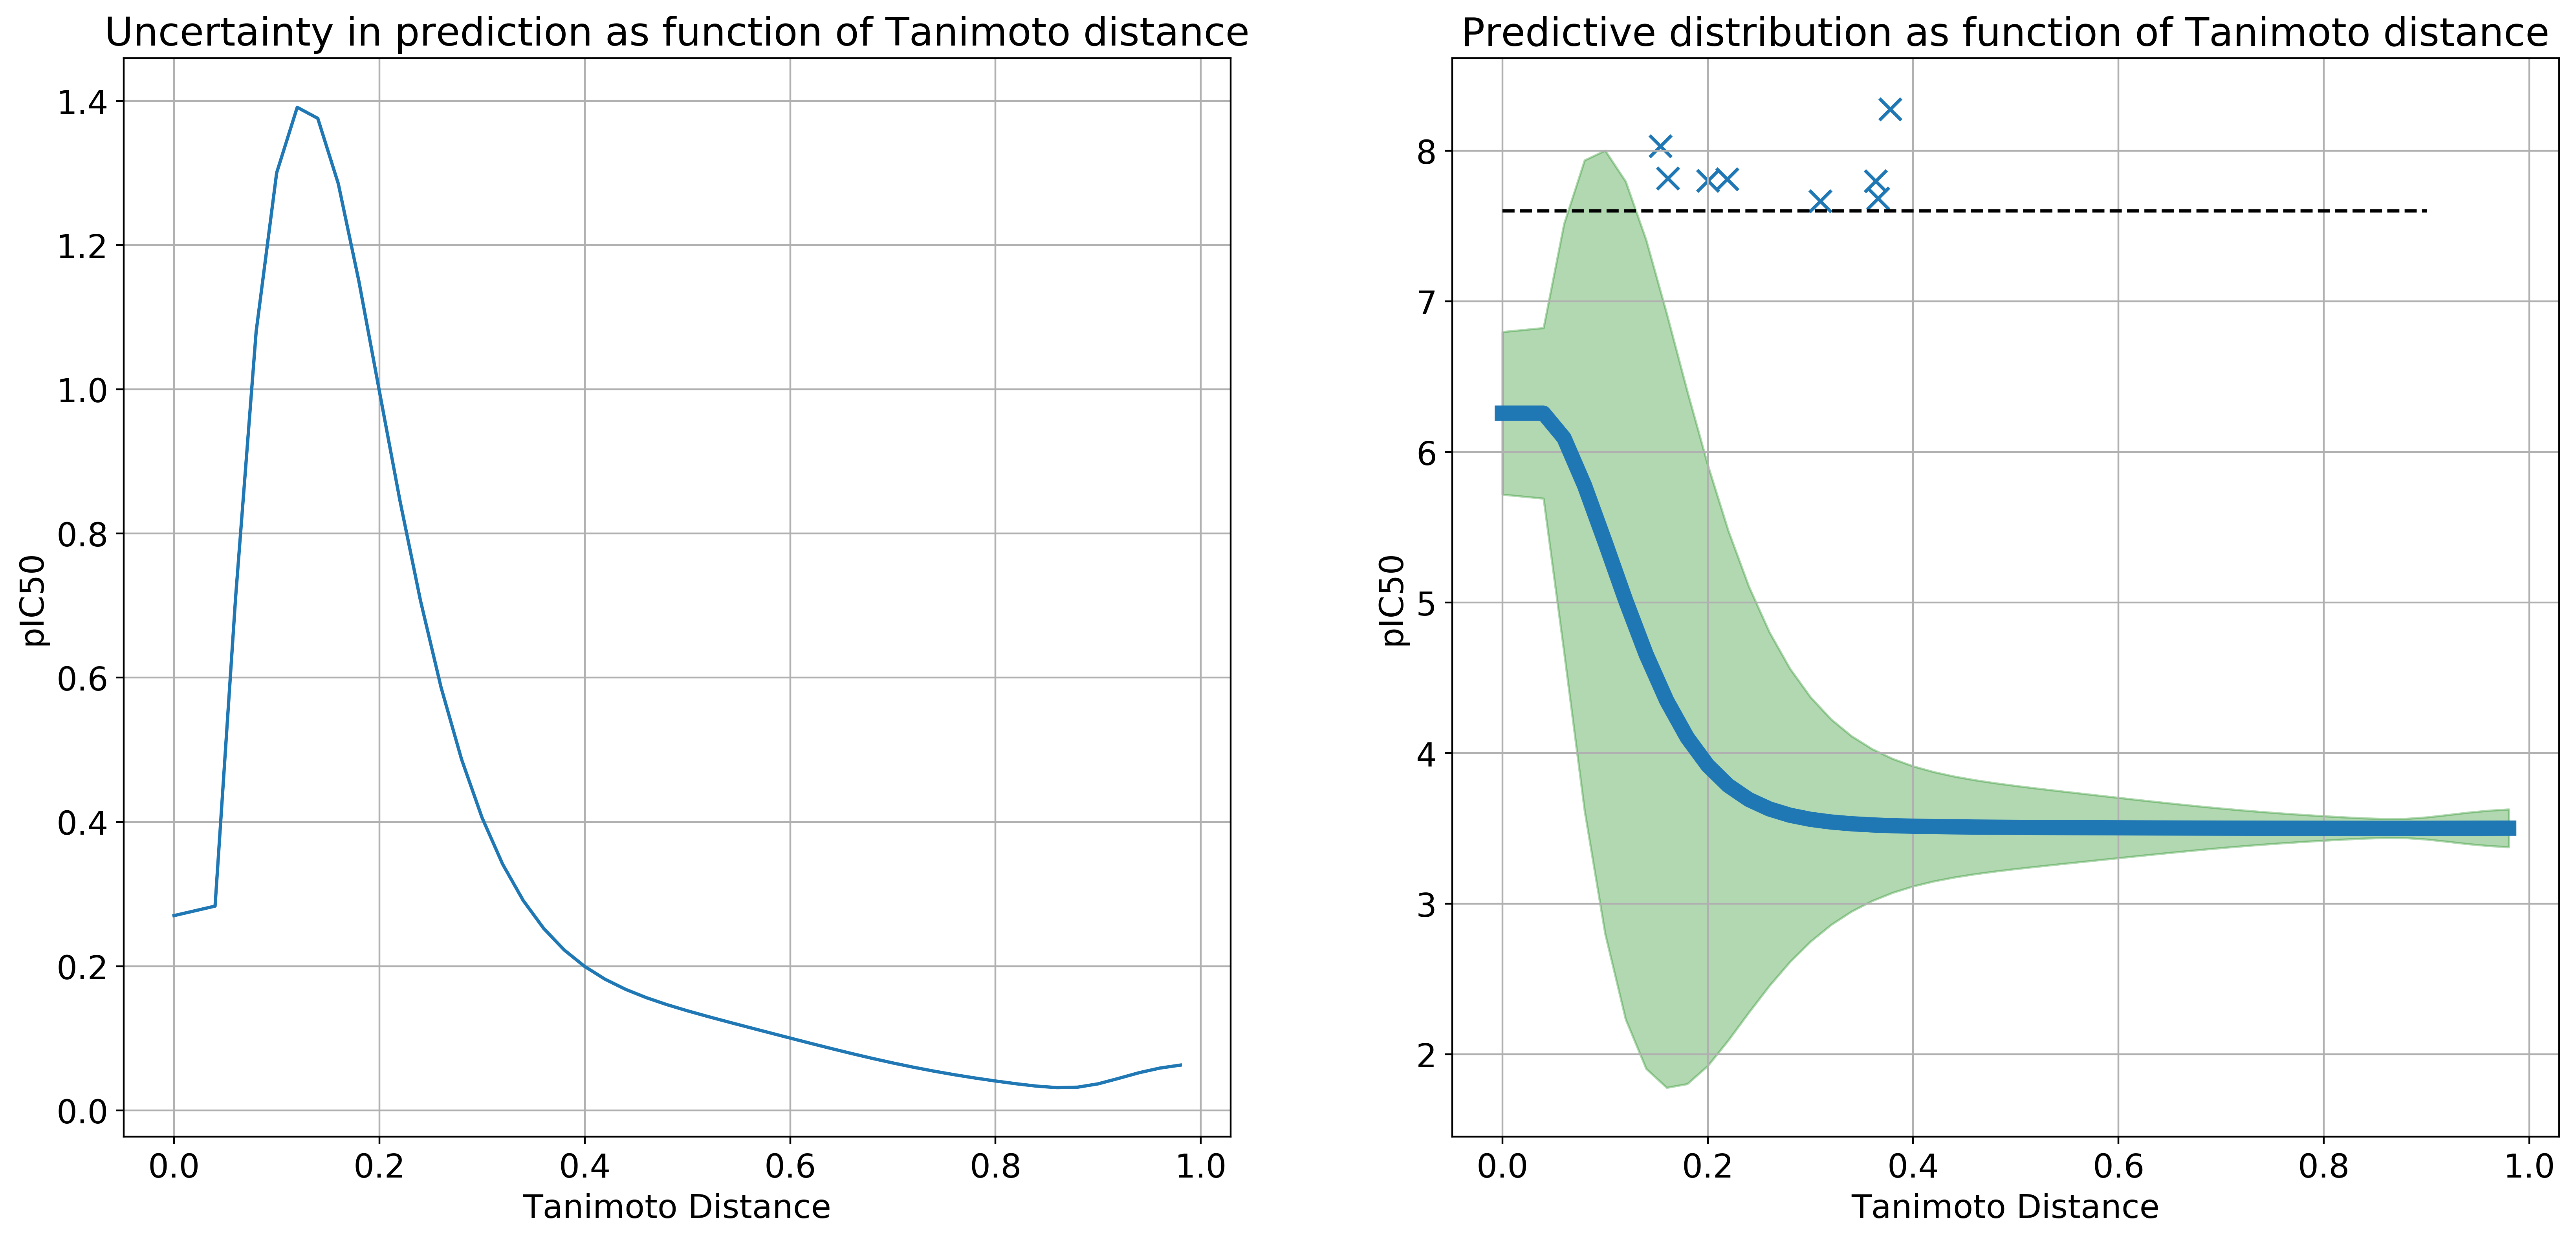

In [107]:
xv = np.arange(50)/50
siga = np.vectorize(calc_sigma)(xv)

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(221)
plt.plot(xv, siga, label='Standard Deviation (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)
plt.title('Uncertainty in prediction as function of Tanimoto distance')
plt.subplot(222)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - 2*siga, yv + 2*siga, color='g', alpha=0.3, 
                 label='Predictive distribution approximation (95%)')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.hlines(7.6, 0, 0.9, linestyles='--', label='Threshold level in our test')
_ = plt.title('Predictive distribution as function of Tanimoto distance')
plt.scatter(gd_dists, gd.pXC50_3D7.values, marker='x', s=100, label='Location of target compounds')
_= plt.ylabel('pIC50')

In [103]:
gd = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6) & (df_tcams_nd['PCT_INHIB_HEPG2'] <= 5)]
# We're going to use the compounds with values < 7.5 for fitting (see Bioinformatics paper)
df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= 7.5)]
# potency random forest model
# set seed so replicable
np.random.seed(42)
pot_model = model_dict['rf']['m'](**model_dict['rf']['kw']).fit(
    np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)


In [104]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists = np.min(cdist(np.asarray([fp for fp in gd.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

In [108]:
from malaria import mp_utils, stats

full_models = stats.fit_models(full_df, full_df)

full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [109]:
gd_fps = np.asarray([fp for fp in gd.fps.values])
gd_active_potency = pot_model.predict(gd_fps)
gd_frac_active = full_models['frac_act'](gd_dists)
gd_rf_beta = full_models['rfb'](gd_dists)
gd_predicted_potency = gd_frac_active * (gd_rf_beta * gd_active_potency + (1-gd_rf_beta)*active_level) +\
    (1-gd_frac_active)*inactive_level

In [110]:
def run_experiment2(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdpp=gd_predicted_potency, gdd=gd_dists):
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    uncertainties = np.vectorize(calc_sigma)(distances)
    
    log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:]

In [111]:
def prob_random(n, A=8, T=20):
    x = 1
    num = n - A
    den = n
    for i in range(T):
        x *= num/den
        num -= 1
        den -= 1
    return 1-x

In [112]:
mp1 = pd.read_pickle('test_df')

In [113]:
import scipy

In [114]:
mp_fps = np.asarray([fp for fp in mp1.fps.values])

mp_active_potency = pot_model.predict(mp_fps)
mp_frac_active = full_models['frac_act'](mp1.min_dist.values)
mp_rf_beta = full_models['rfb'](mp1.min_dist.values)
molport_predicted_potency = mp_frac_active * (mp_rf_beta * mp_active_potency + (1-mp_rf_beta)*active_level) +\
    (1-mp_frac_active)*inactive_level
molport_predicted_potency[np.isnan(molport_predicted_potency)] = 0.

In [115]:
def run_experiment(num_choice=100*1000, to_choose=20,  A=8, gdpp=gd_predicted_potency):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]

In [116]:
_ = run_experiment(30*1000)

Probability of success if random 0.00532
Failed


In [117]:
_ = run_experiment(20*1000)

Probability of success if random 0.00797
Succeeded: 2 found


In [118]:
_ = run_experiment()

Probability of success if random 0.00160
Failed


In [119]:
_ = run_experiment2()

Probability of success if random 0.00160
Failed


In [120]:
def calc_sigma_active(distance):

    act_sigma = 0.27 + 0.33 * distance    
    return act_sigma

In [121]:
def run_experiment3(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdap=gd_active_potency, gdd=gd_dists):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((mp_active_potency[:num_choice], gdap))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    au = np.vectorize(calc_sigma_active)(distances)
    
    #log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    log_lik = np.log(frac_active(distances)) + scipy.stats.norm.logcdf((potency-target)/au)
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:], log_lik[np.argsort(log_lik)[-to_choose:]]


In [122]:
_ = run_experiment3()

Probability of success if random 0.00160
Succeeded: 4 found


In [123]:
_ = run_experiment3(200*1000)

Probability of success if random 0.00080
Succeeded: 2 found


In [124]:
_ = run_experiment3(480*1000)

Probability of success if random 0.00033
Succeeded: 2 found


In [125]:
faa = frac_active(np.arange(0, 1, 0.01))
act_sigmas = calc_sigma_active(np.arange(0, 1, 0.01))
one_pct_line = np.zeros_like(faa)
one_pct_line[faa <= 0.01] = inactive_level
one_pct_line[faa > 0.01] = (active_level + act_sigmas * scipy.stats.norm.ppf(faa).clip(-4,4))[faa > 0.01]

In [126]:
def get_contour_ll_line(target=7.6, start_point=6.5):
    """
    Gets the log-likelihood as a function of distance (log probability of a compound at distance
    d from the starting point having activity >= target).
    """
    d = np.arange(0, 1, 0.01)
    betas = full_models['rfb'](d)
    active_means = betas * start_point + (1 - betas) * active_level
    return np.log(frac_active(d)) +\
        scipy.stats.norm.logcdf((active_means-target)/np.vectorize(calc_sigma_active)(d))

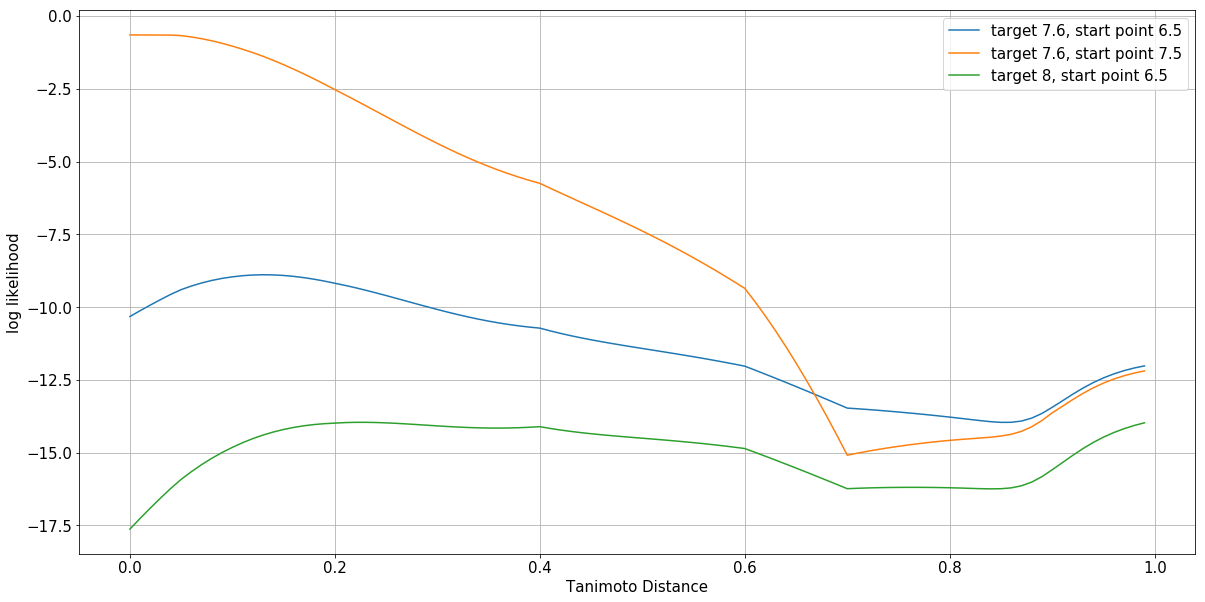

In [127]:
d = np.arange(0, 1, 0.01)
plot(d, get_contour_ll_line(), label='target 7.6, start point 6.5')
plot(d, get_contour_ll_line(start_point=7.5), label='target 7.6, start point 7.5')
plot(d, get_contour_ll_line(target=8), label='target 8, start point 6.5')
ylabel('log likelihood')
xlabel('Tanimoto Distance')
legend(loc='best')
savefig("figures/ll_contour_lines.png")
grid(True)

### Using all compounds with activity > 7.6

In [128]:
gd2 = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6)]

In [129]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists2 = np.min(cdist(np.asarray([fp for fp in gd2.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

In [130]:
gd_fps2 = np.asarray([fp for fp in gd2.fps.values])
gd_active_potency2 = pot_model.predict(gd_fps2)
gd_frac_active2 = full_models['frac_act'](gd_dists2)
gd_rf_beta2 = full_models['rfb'](gd_dists2)
gd_predicted_potency2 = gd_frac_active2 * (gd_rf_beta2 * gd_active_potency2 + (1-gd_rf_beta2)*active_level) +\
    (1-gd_frac_active2)*inactive_level

In [131]:
# Dumb method
_ = run_experiment(num_choice=480*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Failed


In [132]:
_ = run_experiment(num_choice=20*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.18134
Succeeded: 8 found


In [133]:
_ = run_experiment(num_choice=30*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.12506
Failed


In [134]:
# Hacky Ollie method
_ = run_experiment2(num_choice=480*1000, A=201, gdd=gd_dists2, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Succeeded: 2 found


In [135]:
# Correct James method
_ = run_experiment3(num_choice=480*1000, A=201, gdd=gd_dists2, gdap=gd_active_potency2)

Probability of success if random 0.00834
Succeeded: 17 found
